# model training and test

In [1]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg16, VGG16_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

In [2]:
print(torch.__version__)
print(device)

1.12.1+cu113
cuda


In [3]:
vgg16_pretrained = vgg16(weights=VGG16_Weights.DEFAULT)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')
print(vgg16_pretrained)

Turn Off the inplace operation
.
.
.
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_si

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
ROOT_DIR = 'voc_data'

In [5]:
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])

    def __init__(self, root='voc_data/', split='train', transform_tf=True):
        self.root = root
        self.split = split
        self.transform_tf = transform_tf

        # self.transform = transforms.Compose([
        #     transforms.Resize((320,320), interpolation=InterpolationMode.BILINEAR),
        #     transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
        #     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        # ])
        # self.transform_lbl = transforms.Compose([
        #     transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST)
        # ])
        
        self.transform = transforms.Compose([
            transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])


        dataset_dir = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = os.path.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = os.path.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # data file
        data_file = self.files[self.split][index]
        
        # load
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = torch.from_numpy(np.array(img)).to(torch.float)

        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
        lbl = torch.unsqueeze(lbl, dim=0)

        # image preprocessing
        img = img.permute(2, 0, 1) # HWC -> CHW
        lbl[lbl == 255] = -1

        # image transform
        if self.transform_tf == True:
            # return self.transform(img), self.transform_lbl(lbl)
            return self.transform(img), lbl
        else:
            return img, lbl


train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)

train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

In [6]:
# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size, device):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone().to(device)

In [7]:
class FCN18(nn.Module):
  def __init__(self, class_n, device=device): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential(
      nn.Conv2d(3,64,3,padding=100),
      nn.ReLU(inplace=True),
      nn.Conv2d(64,64,3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample2 = nn.Sequential(
      nn.Conv2d(64,128,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128,128,3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample3 = nn.Sequential(
      nn.Conv2d(128,256,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256,256,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256,256,3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample4 = nn.Sequential(
      nn.Conv2d(256,512,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample5 = nn.Sequential(
      nn.Conv2d(512,512,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)

    # fc layers
    self.fc6 = nn.Sequential(
      nn.Conv2d(512, 4096, kernel_size=7, bias=False), 
      nn.ReLU(),
      nn.Dropout2d()
    ).to(device)
    nn.init.xavier_normal_(self.fc6[0].weight)
    self.fc7 = nn.Sequential(
      nn.Conv2d(4096, 4096, kernel_size=1, bias=False), 
      nn.ReLU(),
      nn.Dropout2d()
    ).to(device)
    nn.init.xavier_normal_(self.fc7[0].weight)

    # fc before upsample : to class_n
    self.score_pool3 = nn.Conv2d(256, class_n, kernel_size=1).to(device)
    nn.init.xavier_normal_(self.score_pool3.weight)

    self.score_pool4 = nn.Conv2d(512, class_n, kernel_size=1).to(device)
    nn.init.xavier_normal_(self.score_pool4.weight)

    self.score_final = nn.Conv2d(4096, class_n, kernel_size=1).to(device)
    nn.init.xavier_normal_(self.score_final.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, stride=2, bias=False).to(device) # to 1/16 padding=1,
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4, device))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4,  stride=2, bias=False).to(device) # to 1/8 padding=1,
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4, device))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16,  stride=8, bias=False).to(device) # to 1 padding=4,
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16, device))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False

  def crop_(self, crop_obj, base_obj, crop=True):
      if crop:
          c = (crop_obj.size()[2] - base_obj.size()[2]) // 2
          crop_obj = crop_obj[:,:,c:c+base_obj.shape[2],c:c+base_obj.shape[3]]
          # crop_obj = F.pad(crop_obj, (-c, -c, -c, -c))
          # crop_obj = torchvision.transforms.CenterCrop((base_obj.shape[2], base_obj.shape[3]))
      return crop_obj

  def forward(self, x):
    input_x = x.clone()
    # print("input shape : ", x.shape)
    
    x = self.downsample1(x) # 1/2
    x = self.downsample2(x) # 1/4
    x = self.downsample3(x) # 1/8
    pool3 = x
    x = self.downsample4(x) # 1/16
    pool4 = x
    x = self.downsample5(x) # 1/32

    x = self.fc6(x) # 1/32
    x = self.fc7(x) # 1/32

    x = self.score_final(x)
    x = self.upsample_make_16s(x)
    score_fc_16s = x # 1/16

    x = self.score_pool4(pool4) # 1/16 
    x = self.crop_(x, score_fc_16s)
    score_pool4c = x # 1/16

    x = score_fc_16s + score_pool4c # 1/16
    x = self.upsample_make_8s(x)
    score_fc_8s = x # 1/8

    x = self.score_pool3(pool3)
    x = self.crop_(x, score_fc_8s)
    score_pool3c = x # 1/8

    x = score_fc_8s + score_pool3c # 1/8
    x = self.upsample_to_score(x)
    x = self.crop_(x, input_x)

    out = x
    # print("out shape : ", out.shape)
    return out

In [8]:
epochs = 100
lr = 1e-2
weight_decay = 5e-4 # 1e-4 # 2 ** (-4)
momentum = 0.99

model = FCN18(21).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.5)

# ############################################################ fix this path
# PATH = 'fcn_model/21class_trained/model_8_14_14_14_25_21class' # need to be fixed everytime

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict']) 
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()
# print('train mode start')

In [9]:
# train code
def train(model, epochs, optimizer, criterion, verbos_iter=False, verbos_epoch=True):
  loss_history =[]
  last_LOSS = 10 ** 9

  for epoch in range(epochs):
    running_loss = 0
    for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
      train_img = train_img.to(device)
      # _, _, ori_x, ori_y = train_img.shape # 32로 나누어도 나눠떨어지도록 ...
      # return_transform = transforms.Compose([
      #     transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
      # ])
      train_gt_img = train_gt_img.squeeze(dim=1).to(device)

      # prediction
      score_img = model(train_img)
      score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
      train_gt_img = train_gt_img.reshape(-1, )

      loss = criterion(score_img, train_gt_img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if verbos_iter == True:
        print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

      running_loss += loss
    
    if verbos_epoch == True:
      print('======================================')
      print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

    now = datetime.datetime.now()
    EPOCH = epoch
    PATH = "fcn_model/model_%d_%d_%d_%d_%d" % (now.month, now.day, now.hour, now.minute, now.second)
    LOSS = running_loss

    if last_LOSS > LOSS:
      torch.save({
                  'epoch': EPOCH,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': LOSS,
                  }, PATH)
      loss_history.append(LOSS.item())
      last_LOSS = LOSS
      
    scheduler.step()
  
  print("Training End")
  return loss_history

history = train(model, epochs, optimizer, criterion)

plt.plot(history)
plt.show()

epoch 1, iteration: 1, loss : 3.025225 
epoch 1, iteration: 2, loss : 2.986774 
epoch 1, iteration: 3, loss : 2.945165 
epoch 1, iteration: 4, loss : 2.771079 
epoch 1, iteration: 5, loss : 2.826427 
epoch 1, iteration: 6, loss : 2.744528 
epoch 1, iteration: 7, loss : 2.281945 
epoch 1, iteration: 8, loss : 2.044272 
epoch 1, iteration: 9, loss : 2.351987 
epoch 1, iteration: 10, loss : 1.629521 
epoch 1, iteration: 11, loss : 1.740243 
epoch 1, iteration: 12, loss : 1.411794 
epoch 1, iteration: 13, loss : 1.710388 
epoch 1, iteration: 14, loss : 0.759479 
epoch 1, iteration: 15, loss : 3.584053 
epoch 1, iteration: 16, loss : 0.881202 
epoch 1, iteration: 17, loss : 0.196642 
epoch 1, iteration: 18, loss : 0.804455 
epoch 1, iteration: 19, loss : 4.662870 
epoch 1, iteration: 20, loss : 1.588438 
epoch 1, iteration: 21, loss : 1.823680 
epoch 1, iteration: 22, loss : 1.821593 
epoch 1, iteration: 23, loss : 1.376421 
epoch 1, iteration: 24, loss : 0.363395 
epoch 1, iteration: 25, l

## Test

In [ ]:
test_model = model
test_model.eval()
print('model evaluation start')

In [ ]:
# test_model = FCN18(21)

# ############################################################ fix this path
# PATH = 'fcn_model/model_8_27_19_5_47'

# checkpoint = torch.load(PATH)
# test_model.load_state_dict(checkpoint['model_state_dict'])

# test_model.eval()
# print('model evaluation start')

In [ ]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

idx = 10
test_jpg_path = lines[idx] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    # transforms.Resize((320,320), interpolation=InterpolationMode.BILINEAR),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
return_transform = transforms.Compose([
    transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
])

test_seg = test_model(test_transform(test_image))
test_seg = return_transform(test_seg)
test_seg[test_seg <= 8] = 0 # Thresholding

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0).cpu()

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)
plt.show()

# # model prediction for only one class
# test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
# finding_class = 2 # editable
# test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0

# # to PIL
# test_image_PIL = PIL.Image.fromarray(
#     np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
#     )

# # predicted data showing
# plt.subplot(1,3,3)
# plt.imshow(test_image_PIL)
# plt.show()

In [ ]:
'''
referenced from
https://stackoverflow.com/a/48383182
'''

# IoU function
def iou(pred, target, n_classes = 4):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  # Ignore IoU for background class ("0")
  for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
    pred_inds = pred == cls
    target_inds = target == cls
    
    intersection = int((pred_inds * target_inds).sum().item())
    union = int((pred_inds + target_inds).sum().item())
    
    # print(intersection, union) # for test
    
    if int(target_inds.sum().item()) == 0:
      continue
    
    if union == 0:
      ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / float(union)) # float(max(union, 1)))
    
  return np.array(ious), np.array(ious).mean()

In [ ]:
# for test data
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

iter = 0
iou_stack = 0

for idx in range(len(lines)):
  test_jpg_path = lines[idx] + '.jpg'
  test_png_path = lines[idx] + '.png'
  test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))
  test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "SegmentationObject", test_png_path))

  # test image transform & input to test model
  test_image = np.array(test_image)
  test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
  ori_x, ori_y = test_image.shape[1], test_image.shape[2]
  test_image = torch.unsqueeze(test_image, dim=0)

  test_transform = transforms.Compose([
      # transforms.Resize((320,320), interpolation=InterpolationMode.BILINEAR),
      transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
  return_transform = transforms.Compose([
      transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
  ])

  test_seg = test_model(test_transform(test_image))
  test_seg = return_transform(test_seg)
  # test_seg[test_seg <= 8] = 0 # Thresholdings
  test_seg = torch.squeeze(test_seg, dim=0)

  # model prediction
  test_image_channel_idx = torch.argmax(test_seg, dim=0).cpu()

  # ground truth image getting
  test_gt_image = np.array(test_gt_image)
  test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

  iter += 1
  _, metric = iou(test_image_channel_idx, test_gt_image, 21)
  print("iou of %d th " % (iter), " : ", metric)
  iou_stack += metric

mean_iou = iou_stack / iter
print("mean_iou : ", mean_iou)

In [ ]:
# for train data
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

iter = 0
iou_stack = 0

for idx in range(len(lines)):
  test_jpg_path = lines[idx] + '.jpg'
  test_png_path = lines[idx] + '.png'
  test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))
  test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "SegmentationObject", test_png_path))

  # test image transform & input to test model
  test_image = np.array(test_image)
  test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
  ori_x, ori_y = test_image.shape[1], test_image.shape[2]
  test_image = torch.unsqueeze(test_image, dim=0)

  test_transform = transforms.Compose([
      # transforms.Resize((320,320), interpolation=InterpolationMode.BILINEAR),
      transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
  return_transform = transforms.Compose([
      transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
  ])

  test_seg = test_model(test_transform(test_image))
  test_seg = return_transform(test_seg)
  # test_seg[test_seg <= 8] = 0 # Thresholdings
  test_seg = torch.squeeze(test_seg, dim=0)

  # model prediction
  test_image_channel_idx = torch.argmax(test_seg, dim=0).cpu()

  # ground truth image getting
  test_gt_image = np.array(test_gt_image)
  test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

  iter += 1
  _, metric = iou(test_image_channel_idx, test_gt_image, 21)
  print("iou of %d th " % (iter), " : ", metric)
  iou_stack += metric

mean_iou = iou_stack / iter
print("mean_iou : ", mean_iou)

In [ ]:
def foreground_pixel_acc(pred, gt, class_num):
  true_positive_stack = 0
  all_stack = 0
  for class_i in range(1, class_num+1):
    true_positive = (pred == class_i) * (gt == class_i)
    all = (gt == class_i)

    true_positive_stack += true_positive.sum()
    all_stack += all.sum()

  return true_positive_stack / all_stack

In [ ]:
# foreground pixel accuracy

with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

iter = 0
acc_stack = 0

for idx in range(len(lines)):
  test_jpg_path = lines[idx] + '.jpg'
  test_png_path = lines[idx] + '.png'
  test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))
  test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "SegmentationObject", test_png_path))

  # test image transform & input to test model
  test_image = np.array(test_image)
  test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
  ori_x, ori_y = test_image.shape[1], test_image.shape[2]
  test_image = torch.unsqueeze(test_image, dim=0)

  test_transform = transforms.Compose([
      transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
      transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
  return_transform = transforms.Compose([
      transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
  ])

  test_seg = test_model(test_transform(test_image))
  test_seg = return_transform(test_seg)
  # test_seg[test_seg <= 8] = 0 # Thresholdings
  test_seg = torch.squeeze(test_seg, dim=0)

  # model prediction
  test_image_channel_idx = torch.argmax(test_seg, dim=0).cpu()

  # ground truth image getting
  test_gt_image = np.array(test_gt_image)
  test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

  iter += 1
  metric = foreground_pixel_acc(test_image_channel_idx, test_gt_image, 21)
  print("foreground pixel acc of %d th " % (iter), " : ", metric)
  acc_stack += metric

mean_iou = acc_stack / iter
print("mean_iou : ", mean_iou)

# code for renaming

In [ ]:
# rename image and ground truth files

import os
from google.colab import drive

drive.mount('/content/gdrive')
# ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT'

# 주어진 디렉토리에 있는 항목들의 이름을 담고 있는 리스트를 반환합니다.
# 리스트는 임의의 순서대로 나열됩니다.
file_path1 = os.path.join(ROOT_DIR, 'real_world_data/rgb')
file_names1 = os.listdir(file_path1)
file_names1.sort()
print(file_names1)

i = 1
for name in file_names1:
    src = os.path.join(file_path1, name)
    dst = 'rs_image_' + str(i) + '.jpg'
    dst = os.path.join(file_path1, dst)
    os.rename(src, dst)
    i += 1

file_path2 = os.path.join(ROOT_DIR, 'real_world_data/gt')
file_names2 = os.listdir(file_path2)
file_names2.sort()
print(file_names2)

i = 1
for name in file_names2:
    src = os.path.join(file_path2, name)
    dst = 'rs_gt_' + str(i) + '.png'
    dst = os.path.join(file_path2, dst)
    os.rename(src, dst)
    i += 1

Mounted at /content/gdrive
['rs_image_100_jpg.rf.4613b5e60ee784e8f8e991485621047c.jpg', 'rs_image_100_jpg.rf.531a9ce5062ae15259e53dd0d48f3394.jpg', 'rs_image_100_jpg.rf.cea985d5dfedbd91597d3e23dc7b788e.jpg', 'rs_image_101_jpg.rf.70ed12f31320a8be654fe54e308343a7.jpg', 'rs_image_101_jpg.rf.d264abcfb89938baf36bbc5278bb7828.jpg', 'rs_image_101_jpg.rf.d4c2b8587a1d123d7538d2cf0009aa4e.jpg', 'rs_image_102_jpg.rf.0f63941e7f0bf339e361b4a4cd8c8463.jpg', 'rs_image_102_jpg.rf.3c1632d824ad91c3aed95c34efea5875.jpg', 'rs_image_102_jpg.rf.7ede7c3a247f81b765a575a7c7ccde6c.jpg', 'rs_image_103_jpg.rf.4bd3a2cdc3dd8ed97f77c1678a739072.jpg', 'rs_image_103_jpg.rf.5ab4fcbcf2732ced631fc53616031637.jpg', 'rs_image_103_jpg.rf.64495450141856387f80b4094eb89ddc.jpg', 'rs_image_104_jpg.rf.4b06720b89b2f40f7b57adece44fabec.jpg', 'rs_image_104_jpg.rf.4c5467116523f95f99cb7cf53e0fda41.jpg', 'rs_image_104_jpg.rf.c06df222d400e7542935bdeb1360ac32.jpg', 'rs_image_105_jpg.rf.10c849f0fa70f26d4e0ca2d50df63e7c.jpg', 'rs_image_10

# code for re-training

In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

print(torch.__version__)

1.12.1+cu113


In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
ROOT_DIR = '/voc_data'

# dataset for new image

class VOCClassSegBase(torch.utils.data.Dataset):
  '''
  input size : (480, 640, 3) (480, 640)
  '''

  class_names = np.array([
      'background',
      'roll',
      'sauce',
      'snack',
  ])

  def __init__(self, root='/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT', split='train', transform_tf=True):
      self.root = root
      self.split = split
      self.transform_tf = transform_tf
      self.transform = transforms.Compose([ # interpolation=InterpolationMode.BILINEAR
          transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
          transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
      ])

      file_names_rgb = os.listdir(os.path.join(ROOT_DIR, 'real_world_data/rgb'))
      file_names_rgb.sort()

      DATASET_DIR = os.path.join(self.root, 'real_world_data')
      self.files = collections.defaultdict(list)
      for split in ['train', 'val']:
        for i in range(len(file_names_rgb)):
            img_file = os.path.join(DATASET_DIR, 'rgb/rs_image_%d.jpg' % (i + 1))
            lbl_file = os.path.join(DATASET_DIR, 'gt/rs_gt_%d.png' % (i + 1))
            self.files[split].append({
                'img': img_file,
                'lbl': lbl_file,
            })

  def __len__(self):
      return len(self.files[self.split])

  def __getitem__(self, index):
      # data file
      data_file = self.files[self.split][index]
      
      # load
      img_file = data_file['img']
      img = PIL.Image.open(img_file)
      img = torch.from_numpy(np.array(img)).to(torch.float)

      lbl_file = data_file['lbl']
      lbl = PIL.Image.open(lbl_file)
      lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
      lbl = torch.unsqueeze(lbl, dim=0)

      # 반드시 확인해야할 것
      # image preprocessing
      img = img.permute(2, 0, 1) # HWC -> CHW 
      lbl[lbl == 255] = -1

      # image transform
      if self.transform_tf == True:
          return self.transform(img), lbl
      else:
          return img, lbl

train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)
train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

Mounted at /content/gdrive


In [ ]:
# resnet pretrained download
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

print('Done.')

# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

# FCN18 declaration
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7)
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Turn Off the inplace operation
.
.
.
Done.


In [ ]:
# import copy

# epochs = 30
# lr = 10e-4
# weight_decay = 1e-8
# momentum = 0.9

# # data loading from the file
# model = FCN18(4)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ############################################################ fix this path. need to be fixed everytime
# PATH = '/fcn_model/21class_trained/model_8_14_14_14_25_21class'

# checkpoint = torch.load(PATH)
# state_dict = checkpoint['model_state_dict']
# new_state_dict = collections.OrderedDict()

# with torch.no_grad():
#   for key in state_dict:
#     if key.split('.')[0][:-1] == 'downsample':
#       new_state_dict[key] = copy.deepcopy(state_dict[key])

# model.load_state_dict(new_state_dict,strict=False) 

# model.train()
# print('train mode start')

# model.downsample1.requires_grad = False
# model.downsample2.requires_grad = False
# model.downsample3.requires_grad = False
# model.downsample4.requires_grad = False
# model.downsample5.requires_grad = False

In [ ]:
# # 이어서 학습할 때 사용
# epochs = 6
# lr = 10e-5
# weight_decay = 1e-8
# momentum = 0.9

# # data loading from the file
# model = FCN18(4)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ############################################################ fix this path
# PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_8_17_0_18_43'

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()
# print('train mode start')

In [ ]:
# # train code
# def train(model, epochs, optimizer, criterion):
#   # with torch.autograd.detect_anomaly():
#   for epoch in range(epochs):
#     running_loss = 0
#     for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
#       train_img = train_img.to(device)
#       train_gt_img = train_gt_img.squeeze(dim=1).to(device)

#       score_img = model(train_img)
#       score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
#       train_gt_img = train_gt_img.reshape(-1, )

#       loss = criterion(score_img, train_gt_img)

#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

#       running_loss += loss
    
#     print('======================================')
#     print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

#     now = datetime.datetime.now()
#     EPOCH = epoch
#     PATH = "/fcn_model/model_%d_%d_%d_%d_%d" % (now.month, now.day, now.hour, now.minute, now.second)
#     LOSS = running_loss / len(train_data_loader)

#     torch.save({
#                 'epoch': EPOCH,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': LOSS,
#                 }, PATH)
#     scheduler.step()
  
#   print("Training End")
#   return (now.month, now.day, now.hour, now.minute, now.second)

# month, day, hour, minute, second = train(model, epochs, optimizer, criterion)

## Test

In [ ]:
test_model = FCN18(4)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/4class_trained/model_8_17_7_31_29'
print(PATH)

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

test_model.eval()
print('model evaluation start')

/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/4class_trained/model_8_17_7_31_29
model evaluation start


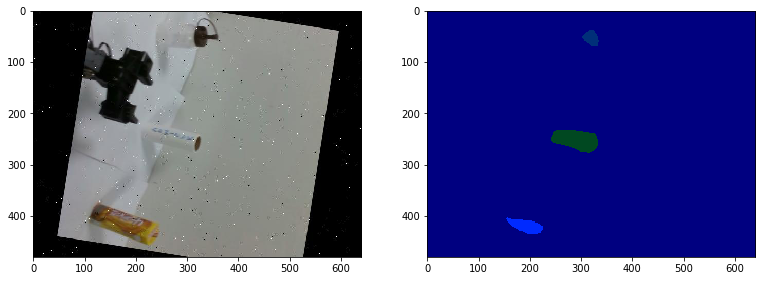

In [ ]:
# segmentation : plot image
img_num = 8
test_image = PIL.Image.open('/real_world_data/rgb/rs_image_%d.jpg' % (img_num))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)
test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([ # interpolation=InterpolationMode.BILINEAR
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_seg = test_model(test_transform(test_image))
test_seg = torch.squeeze(test_seg, dim=0)
# model prediction
test_image_channel_idx = torch.argmax(test_seg, dim=0)

# print(test_image_channel_idx[30, 75])

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)
plt.show()

In [ ]:
'''
referenced from
https://stackoverflow.com/a/48383182
'''

# IoU function
def iou(pred, target, n_classes = 4):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  # Ignore IoU for background class ("0")
  for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
    pred_inds = pred == cls
    target_inds = target == cls
    
    intersection = int((pred_inds * target_inds).sum().item())
    union = int((pred_inds + target_inds).sum().item())
    
    print(intersection, union) # for test 
    
    if int(target_inds.sum().item()) == 0:
      continue
    
    if union == 0:
      ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / float(union)) # float(max(union, 1)))
    
  return np.array(ious), np.array(ious).mean()

In [ ]:
NUMM =1

In [ ]:
# testing

print(NUMM)

test_rgb_image = PIL.Image.open(os.path.join(ROOT_DIR, 'real_world_data/rgb', 'rs_image_{}.jpg'.format(NUMM)))
test_rgb_image = np.array(test_rgb_image)
test_rgb_image = torch.from_numpy(test_rgb_image).to(torch.float).permute(2,0,1)
test_rgb_image = torch.unsqueeze(test_rgb_image, dim=0)

test_transform = transforms.Compose([
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_seg = test_model(test_transform(test_rgb_image))
test_seg = torch.squeeze(test_seg, dim=0)
test_image_channel_idx = torch.argmax(test_seg, dim=0)

# gt image getting
test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'real_world_data/gt', 'rs_gt_{}.png'.format(NUMM)))
test_gt_image = np.array(test_gt_image)
test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

NUMM +=1

iou(test_image_channel_idx, test_gt_image)


1
3415 5775
3757 4440
2795 3977


(array([0.59134199, 0.84617117, 0.70279105]), 0.7134347370140682)

In [ ]:
file_names1 = os.listdir(os.path.join(ROOT_DIR, 'real_world_data/rgb'))
file_names1.sort()

file_names2 = os.listdir(os.path.join(ROOT_DIR, 'real_world_data/gt'))
file_names2.sort()

iter = 0
iou_stack = 0

for idx in range(len(file_names1)):
  test_rgb_image = PIL.Image.open(os.path.join(ROOT_DIR, 'real_world_data/rgb', file_names1[idx]))
  test_rgb_image = np.array(test_rgb_image)
  test_rgb_image = torch.from_numpy(test_rgb_image).to(torch.float).permute(2,0,1)
  test_rgb_image = torch.unsqueeze(test_rgb_image, dim=0)

  test_transform = transforms.Compose([
      transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])

  test_seg = test_model(test_transform(test_rgb_image))
  test_seg = torch.squeeze(test_seg, dim=0)
  test_image_channel_idx = torch.argmax(test_seg, dim=0)

  # gt image getting
  test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'real_world_data/gt', file_names2[idx]))
  test_gt_image = np.array(test_gt_image)
  test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

  iter += 1
  _, metric = iou(test_image_channel_idx, test_gt_image)
  print("iou of ", file_names1[idx], "and", file_names2[idx], " : ", metric)
  iou_stack += metric
  
mean_iou = iou_stack / iter
print("mean_iou : ", mean_iou)

3415 5775
3757 4440
2795 3977
iou of  rs_image_1.jpg and rs_gt_1.png  :  0.7134347370140682
3110 4525
1502 4359
5234 5740
iou of  rs_image_10.jpg and rs_gt_10.png  :  0.6479046504182571
4237 5536
0 0
0 0
iou of  rs_image_100.jpg and rs_gt_100.png  :  0.7653540462427746
5098 5552
0 0
0 0
iou of  rs_image_101.jpg and rs_gt_101.png  :  0.9182276657060519
4469 5443
0 0
0 0
iou of  rs_image_102.jpg and rs_gt_102.png  :  0.8210545654969685
4558 5547
0 0
0 0
iou of  rs_image_103.jpg and rs_gt_103.png  :  0.8217054263565892
3718 5613
0 0
0 0
iou of  rs_image_104.jpg and rs_gt_104.png  :  0.6623908783181899
5085 5633
0 0
0 0
iou of  rs_image_105.jpg and rs_gt_105.png  :  0.9027161370495296
0 146
3016 4235
0 0
iou of  rs_image_106.jpg and rs_gt_106.png  :  0.3560802833530106
0 147
3001 4223
0 0
iou of  rs_image_107.jpg and rs_gt_107.png  :  0.35531612597679374
0 150
3903 4497
0 0
iou of  rs_image_108.jpg and rs_gt_108.png  :  0.43395597064709807
0 148
3725 4666
0 0
iou of  rs_image_109.jpg and r